In [1]:
import sys
sys.path.append('/Users/bryangonzalez/Documents/Dartmouth/Research/TheoryOfMind_Bx_experiment/Code/models/')
sys.path.append('/Users/bryangonzalez/Documents/Dartmouth/Research/TheoryOfMind_Bx_experiment/Code/')
import pandas as pd
import numpy as np
import scipy
from scipy.optimize import least_squares
import p3_cost_funcs
import comp_models
import utils
import seaborn as sns


dat = pd.read_csv('../data/bx_data.csv', index_col=0)
dat = dat[['trustee','turker_id', 'trial', 'inv','mult', 'im', 'exp','pred', 'ret', 'p2_strat']]

niter = 300
results = pd.DataFrame(columns=['trueAlpha', 'trueTau', 'recovAlpha', 'recovTau', 'cost', 'r'])
dat.head()

,trustee,turker_id,trial,inv,mult,im,exp,pred,ret,p2_strat
0,93,1,0,5,2,10,10,5,7,GA
1,93,1,1,9,2,18,18,7,14,GA
2,93,1,2,8,4,32,16,20,16,GA
3,93,1,3,5,4,20,10,9,10,GA
4,93,1,4,3,2,6,6,3,4,GA


In [ ]:
for turk in dat.turker_id.unique()[:10]:
    print('simulating/recovering turker:', turk)
    # simulate with arbitrary params
    game = dat.loc[dat.turker_id == turk]
    truAlpha = np.random.uniform()
    truTau = np.random.uniform(low=.001)
    truGame = game.copy()
    truGame['pred'] = comp_models.imm_learn(game=truGame,folk_thry=utils.folk_params, alpha=truAlpha,tau=truTau)
    #Fit the simulation
    fitIters = np.zeros([niter, 5])
    for i in range(niter):
        param0 = [np.random.uniform(), np.random.uniform(low=.001)]
        fitIters[i,0:2] = [param0[0], param0[1]]
        result_lsq = least_squares(fun=p3_cost_funcs.imm_costfun, x0=param0, args=(truGame,utils.folk_params ),
                                   bounds=([0,.001], [1,1]), diff_step=.05)

        [param1, param2] = result_lsq.x
        cost = result_lsq.cost
        fitIters[i, 2:5] = [param1, param2, cost]
    cost_selected = np.min(fitIters[:, 4])
    recovAlpha = fitIters[fitIters[:,4]== cost_selected, 2][0]
    recovTau = fitIters[fitIters[:,4]== cost_selected, 3][0]
    sse = cost_selected* 2
    #simulate with fitted params
    recovGame = game.copy()
    recovGame['pred'] = comp_models.imm_learn(game=recovGame,folk_thry=utils.folk_params, alpha=recovAlpha,tau= recovTau).astype(int).tolist()
    # correlate initial and recovered model predictions
    r = scipy.stats.pearsonr( truGame['pred'], recovGame['pred'] )[0]
    results = results.append(pd.DataFrame([[truAlpha, truTau, recovAlpha, recovTau, sse, r]],
                                          columns=results.columns)).reset_index(drop=True)
   # if turk%5 == 0:
    #    results.to_csv('results/param_recov_'+str(niter)+'iters_newBounds.csv', sep=',')

simulating/recovering turker: 1
simulating/recovering turker: 3


In [6]:
results.to_csv('results/param_recov_'+str(niter)+'iters.csv', sep=',')


In [24]:
results = pd.read_csv('results/param_recov_300iters.csv', index_col=0).reset_index(drop=True)

results['r_val'] = [float(results['r'][x].strip(')(').split(',')[0]) for x in np.arange(len(results))]
results['corr_pVal'] = [float(results['r'][x].strip(')(').split(',')[1]) for x in np.arange(len(results))]

In [31]:
trialCorr = np.mean(results['r_val'])
alphaCorr = scipy.stats.pearsonr(results['trueAlpha'],results['recovAlpha'])
tauCorr = scipy.stats.pearsonr(results['trueTau'],results['recoveTau'])
print(trialCorr)
print(alphaCorr)
print(tauCorr)
scipy.stats.ttest_1samp(results['r_val'],0,nan_policy='omit')

0.5305454756327087
(-0.0032519565442005495, 0.9483047672823087)
(0.12045695834534006, 0.015935804412247952)


Ttest_1sampResult(statistic=85.93867093720115, pvalue=1.609203566732394e-259)

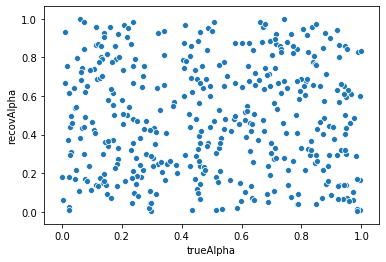

In [32]:
import seaborn as sns
sns.scatterplot(x='trueAlpha', y='recovAlpha', data=results)

In [28]:
scipy.stats.pearsonr(results['trueAlpha'],results['recovAlpha'])

KeyError: 'truAlpha'